# Predecir si el ejercicio es correcto
Aplicar Machine Learning para predecir si el paciente está realizando correctamente el ejercicio (clasificación binaria)

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter


# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object)

In [3]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

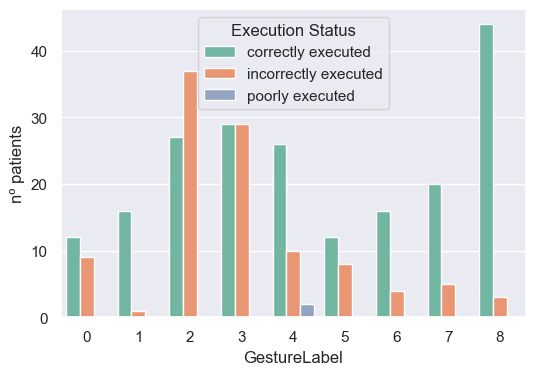

In [4]:
#---------Distribución de las clases--------
plt.figure(figsize=(6,4))
sns.countplot(x="GestureLabel", hue="CorrectLabel",  data=df, palette = "Set2")
plt.legend(title='Execution Status', labels=["correctly executed", "incorrectly executed", "poorly executed"])
plt.ylabel('nº patients')
plt.show()

In [5]:
df[df['CorrectLabel']==3] = 2

In [6]:
#-------Funciones--------

# Para entrenat los modelos de ML
def aplicar_modelos( X:pd.DataFrame, y:pd.DataFrame, tX:pd.DataFrame, ty:pd.DataFrame):
   """
   Aplica una lista de modelos de aprendizaje automático a los datos de prueba y muestra
   los informes de evaluación.

   Parámetros:
   * X: datos de entrenamiento.
   * y: target de entrenamiento.
   * tX: datos de prueba.
   * ty: target de prueba.
   """
   # creación de los modelos
   knn = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
   dtree = DecisionTreeClassifier() # Decision tree
   nb = GaussianNB() # Naive Bayes
   svm = SVC() # Suport Vector Machine
   rf = RandomForestClassifier(n_estimators = 5)  # Random Forest
   lr = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

   models = [knn, dtree, nb, svm, rf, lr]
   
   # Iteramos sobre los modelos
   for modelo in models:
      modelo.fit(X,y) # entrenamos el modelo
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 
    
# Aplicar imbalance learn
def aplicar_imblearn(X,y, tX, ty):
   nm1 = NearMiss(version=1, n_neighbors=2)
   enn = EditedNearestNeighbours()
   adasyn = ADASYN(n_neighbors = 2)
   smote = SMOTE()
   smotetomek = SMOTETomek()
   smote_enn = SMOTEENN(random_state=0)

   imblearns = [nm1, enn, adasyn, smote, smotetomek, smote_enn]
   for imblearn in imblearns:
      try:
         X_train_im, y_train_im = imblearn.fit_resample(X, y)
         print(f"\n- MODELO DE RESAMPLING: {imblearn.__class__.__name__}") 
         print ("Distribution of class labels before resampling {}".format(Counter(y)))
         print ("Distribution of class labels after resampling {}".format(Counter(y_train_im)))
         aplicar_modelos(X_train_im, y_train_im, tX, ty)
      except ValueError as e:
            if "No samples will be generated" in str(e):
                print(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}")
            elif "Expected n_neighbors" in str(e):
                print(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}")
            else:
                raise e
      except RuntimeError as e:
            if "ADASYN is not suited for this specific dataset" in str(e):
                print(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}")
            else:
                raise e
      

In [7]:
gestures  = [0, 2, 3,4,5,6,7,8]#df['GestureLabel'].unique()

for gesture in gestures:

    if gesture == 1:
        pass

    df_gesture = df[df['GestureLabel']==gesture]

    #---------Dividimos el dataset------------
    #---------Dividimos en train y test------------
    df_train, df_test = train_test_split(df_gesture, test_size = 0.3, stratify=df_gesture['CorrectLabel'])

    # Dividimos el conjunto de train en varibales independientes y en target
    X_train = df_train.drop(['CorrectLabel'], axis = 1)
    y_train = pd.DataFrame(df_train['CorrectLabel'])

    # Dividimos el conjunto de test
    X_test = df_test.drop(['CorrectLabel'], axis = 1)
    y_test = pd.DataFrame(df_test['CorrectLabel'])

    # Convertimos los df de target (y) a 1-d
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    print('------------CLASIFICACIÓN GESTO ' + str(gesture) + ' -----------')
    aplicar_imblearn(X_train, y_train, X_test, y_test)

------------CLASIFICACIÓN GESTO 0 -----------

- MODELO DE RESAMPLING: NearMiss
Distribution of class labels before resampling Counter({1: 8, 2: 6})
Distribution of class labels after resampling Counter({1: 6, 2: 6})

Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7


Modelo: GaussianNB
              precision    recall  f1-score   s